In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import pandas as pd
import numpy as np
from sglm.helpers import filehelpers as fh, dfhelpers as dfh
from collections import defaultdict
from pathlib import Path

In [4]:
base_keys = list({
                'gACH':(0,0),
                'rDA':(0,0),
                'gDA':(0,0),
                'photometryCenterInIndex':(0,0),
                'photometryCenterOutIndex':(0,0),
                'photometrySideInIndex':(0,0),
                'photometrySideInIndexr':(0,0),
                'photometrySideOutIndex':(0,0),
                'sl': (0,0),
                'spnnrOff': (0,0),
                'photometryCenterInIndex':(0,0),
                'photometryCenterOutIndex':(0,0),
                'photometrySideInIndexAA':(0,0),
                'photometrySideInIndexAa':(0,0),
                'photometrySideInIndexaA':(0,0),
                'photometrySideInIndexaa':(0,0),
                'photometrySideInIndexAB':(0,0),
                'photometrySideInIndexAb':(0,0),
                'photometrySideInIndexaB':(0,0),
                'photometrySideInIndexab':(0,0),
                'photometrySideOutIndex':(0,0),
                'sl': (0,0),
                'spnnrOff': (0,0),
                }.keys())
# base_keys

used_run_majors = ['base_simple', 'base_words']


In [5]:
h5_lst = defaultdict(list)
run_id_dct = defaultdict(list)

# base_location = Path(r'/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/outputs')
base_location = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs')

fig_folder_lst = [('Figure_1_2', 'f1*-ft'),
                  ('Figure_3',   'f3*-ft'),
                  ('Figure_4_g1',   'f4*-ft'),
                  ('Figure_4_g2',   'f4*-ft'),
                  ('Figure_5_g1',   'f5*-ft'),
                  ('Figure_5_g2',   'f5*-ft'),
                  ('Figure_5_g5',   'f5*-ft'),
                 ]

for fig_folder in fig_folder_lst:
    print('fig_folder', fig_folder)
    
    load_folder = base_location / Path(fig_folder[0])
    # load_folder = base_location / Path(r'tmp')
    h5_beta_locations = str((load_folder / Path('all') / Path(fig_folder[1]) / Path(r'coefs\*_best_coeffs.h5')).resolve())
    
    print(h5_beta_locations)
    


#     base_location = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs')

#     load_folder = base_location / Path(r'Figure_1_2')
#     h5_beta_locations = str((load_folder / Path(r'all\f1*-ft\coefs\*_best_coeffs.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_3')
#     # h5_beta_locations = str((load_folder / Path(r'all\f3*-ft\coefs\*_best_coeffs.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_4_g1')
#     # h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\coefs\*_best_coeffs.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_4_g2')
#     # h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\coefs\*_best_coeffs.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_5_g1')
#     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_5_g2')
#     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())

#     out_folder = base_location / Path(r'final_outputs')

#     # h5_beta_locations = Path('/Users/josh/Dropbox (HMS)/jz/Tetanus/1194_1195_1214_1258_1259_2_best_coeffs.h5')
#     out_loc = str((out_folder).resolve())
#     h5_beta_locations = glob.glob(h5_beta_locations)


    out_folder = base_location / Path(r'final_outputs')

    out_loc = str((out_folder).resolve())
    h5_beta_locations = glob.glob(h5_beta_locations)


    h5_lst = defaultdict(list)
    for h5_coef_fn in h5_beta_locations:
        h5f = pd.HDFStore(h5_coef_fn)
        h5fk = h5f.keys()
        for key in h5fk:
            print(key)
            resp = key.split('_')[0].replace('/', '')
            model_version = '_'.join(key.split('_')[3:]).split('_run_num')[0]
    #         print(resp, model_version)
            h5_df = pd.read_hdf(h5f, key).reset_index()
            h5_df['fn'] = h5_coef_fn
            h5_df['key'] = key
            h5_df = h5_df.set_index(['fn','key'])


            h5_df = h5_df.sort_values('channel_name')
            h5_df['channel'] = h5_df['channel_name'].str.split('_').apply(lambda x: x[0])
            h5_df['run_num'] = h5_df['channel_name'].str.split('_').apply(lambda x: x[-1])

            h5_lst[(resp, model_version)].append(h5_df)
    #         h5_lst.append(h5_df)
    # concat = pd.concat(h5_lst, axis=0)

    fh.create_folder_if_not_exists(out_loc)



    a = None
    b = None

    h5_dfs = dict(h5_lst)
    for key in h5_dfs:
        run_major = '='.join(key)

        cont = True
        for runmajor in used_run_majors:
            if runmajor in run_major:
                cont = False
        if cont:
            continue

        val = h5_dfs[key]
        concat = pd.concat(val)

        all_kernels = []
        for base_key in base_keys:
            all_kernels += dfh.get_kernel_from_basename(base_key, list(concat.columns))


        gb_columns = ['mouse_id', 'channel', 'name']
        ak_unagg = concat.reset_index().set_index(['mouse_id', 'channel', 'name', 'run_num'])[all_kernels]

        ak_unagg.to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-kernels_raw-{run_major}.csv').resolve()))

        kernels = ak_unagg.groupby(gb_columns).agg([np.mean, np.size, np.std])
        kernels = kernels.swaplevel(axis=1)

        ak = concat[all_kernels].copy()
        new_cols = [(dfh.shorten_col_name(_.split('_')[0]), int(_.split('_')[1])) for _ in ak.columns]



        ak.columns = pd.MultiIndex.from_tuples(new_cols)
        ak['1'] = 1
        akgb = ak.groupby('1').agg([np.mean, np.size, np.std]).stack().sort_index().droplevel(0).copy()
        akgb.loc['sem'] = akgb.loc['std']/np.sqrt(akgb.loc['size'])
    #     akgb = akgb.loc[['mean', 'sem']]
        final_out = akgb.stack(1).unstack(0).copy()
        final_out.columns = ['_'.join(_) for _ in final_out.columns]

    #     if a is None:
    #         a = final_out
    #     else:
    #         b = final_out
    #         break

    #     print(final_out.shape)
        final_out.to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-kernels-{run_major}.csv').resolve()))
        
#         display(final_out)

    #     break

fig_folder ('Figure_1_2', 'f1*-ft')
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\Figure_1_2\all\f1*-ft\coefs\*_best_coeffs.h5
/gACH_0_0_base_simple_run_num__0
/gACH_0_0_base_simple_run_num__1
/gACH_0_0_base_simple_run_num__2
/gACH_0_0_base_simple_run_num__3
/gACH_0_0_base_simple_run_num__4
/gACH_0_0_base_simple_run_num__5
/gACH_0_0_base_simple_run_num__6
/gACH_0_0_base_simple_run_num__7
/gACH_0_0_base_simple_run_num__8
/gACH_0_0_base_simple_run_num__9
/gACH_0_1_no_CI_run_num__0
/gACH_0_1_no_CI_run_num__1
/gACH_0_1_no_CI_run_num__2
/gACH_0_1_no_CI_run_num__3
/gACH_0_1_no_CI_run_num__4
/gACH_0_1_no_CI_run_num__5
/gACH_0_1_no_CI_run_num__6
/gACH_0_1_no_CI_run_num__7
/gACH_0_1_no_CI_run_num__8
/gACH_0_1_no_CI_run_num__9
/gACH_0_2_no_CO_run_num__0
/gACH_0_2_no_CO_run_num__1
/gACH_0_2_no_CO_run_num__2
/gACH_0_2_no_CO_run_num__3
/gACH_0_2_no_CO_run_num__4
/gACH_0_2_no_CO_run_num__5
/gACH_0_2_no_CO_run_num__6
/gACH_0_2_no_CO_run_num__7
/gACH_0_2_no_CO_run_num__8
/gACH_0_2_no_CO_

C:\Users\Josh\AppData\Local\Temp\ipykernel_23516\1960336636.py:119: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  akgb = ak.groupby('1').agg([np.mean, np.size, np.std]).stack().sort_index().droplevel(0).copy()
C:\Users\Josh\AppData\Local\Temp\ipykernel_23516\1960336636.py:119: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  akgb = ak.groupby('1').agg([np.mean, np.size, np.std]).stack().sort_index().droplevel(0).copy()
C:\Users\Josh\AppData\Local\Temp\ipykernel_23516\1960336636.py:119: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  akgb = ak.groupby('1').agg([np.mean, np.size, np.std]).stack().sort_index().droplevel(0).copy()


fig_folder ('Figure_3', 'f3*-ft')
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\Figure_3\all\f3*-ft\coefs\*_best_coeffs.h5
/gACH_0_0_gDA_to_gACH_run_num__0
/gACH_0_0_gDA_to_gACH_run_num__1
/gACH_0_0_gDA_to_gACH_run_num__2
/gACH_0_0_gDA_to_gACH_run_num__3
/gACH_0_0_gDA_to_gACH_run_num__4
/gACH_0_0_gDA_to_gACH_run_num__5
/gACH_0_0_gDA_to_gACH_run_num__6
/gACH_0_0_gDA_to_gACH_run_num__7
/gACH_0_0_gDA_to_gACH_run_num__8
/gACH_0_0_gDA_to_gACH_run_num__9
/gACH_0_1_rDA_to_gACH_run_num__0
/gACH_0_1_rDA_to_gACH_run_num__1
/gACH_0_1_rDA_to_gACH_run_num__2
/gACH_0_1_rDA_to_gACH_run_num__3
/gACH_0_1_rDA_to_gACH_run_num__4
/gACH_0_1_rDA_to_gACH_run_num__5
/gACH_0_1_rDA_to_gACH_run_num__6
/gACH_0_1_rDA_to_gACH_run_num__7
/gACH_0_1_rDA_to_gACH_run_num__8
/gACH_0_1_rDA_to_gACH_run_num__9
/gACH_0_2_base_simple_gDA_to_gACH_run_num__0
/gACH_0_2_base_simple_gDA_to_gACH_run_num__1
/gACH_0_2_base_simple_gDA_to_gACH_run_num__2
/gACH_0_2_base_simple_gDA_to_gACH_run_num__3
/gACH_0_2_base_simple_g

C:\Users\Josh\AppData\Local\Temp\ipykernel_23516\1960336636.py:119: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  akgb = ak.groupby('1').agg([np.mean, np.size, np.std]).stack().sort_index().droplevel(0).copy()
C:\Users\Josh\AppData\Local\Temp\ipykernel_23516\1960336636.py:119: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  akgb = ak.groupby('1').agg([np.mean, np.size, np.std]).stack().sort_index().droplevel(0).copy()
C:\Users\Josh\AppData\Local\Temp\ipykernel_23516\1960336636.py:119: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  akgb = ak.groupby('1').agg([np.mean, np.size, np.std]).stack().sort_index().droplevel(0).copy()
C:\Users\Josh\AppData\Local\Temp\ipykernel_23516\1960336636.py:119: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact perform

fig_folder ('Figure_4_g1', 'f4*-ft')
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\Figure_4_g1\all\f4*-ft\coefs\*_best_coeffs.h5
/gDA_0_0_base_simple_run_num__0
/gDA_0_0_base_simple_run_num__1
/gDA_0_0_base_simple_run_num__2
/gDA_0_0_base_simple_run_num__3
/gDA_0_0_base_simple_run_num__4
/gDA_0_0_base_simple_run_num__5
/gDA_0_0_base_simple_run_num__6
/gDA_0_0_base_simple_run_num__7
/gDA_0_0_base_simple_run_num__8
/gDA_0_0_base_simple_run_num__9
/gDA_0_1_base_words_run_num__0
/gDA_0_1_base_words_run_num__1
/gDA_0_1_base_words_run_num__2
/gDA_0_1_base_words_run_num__3
/gDA_0_1_base_words_run_num__4
/gDA_0_1_base_words_run_num__5
/gDA_0_1_base_words_run_num__6
/gDA_0_1_base_words_run_num__7
/gDA_0_1_base_words_run_num__8
/gDA_0_1_base_words_run_num__9


C:\Users\Josh\AppData\Local\Temp\ipykernel_23516\1960336636.py:119: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  akgb = ak.groupby('1').agg([np.mean, np.size, np.std]).stack().sort_index().droplevel(0).copy()


fig_folder ('Figure_4_g2', 'f4*-ft')
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\Figure_4_g2\all\f4*-ft\coefs\*_best_coeffs.h5
/gDA_0_0_base_simple_run_num__0
/gDA_0_0_base_simple_run_num__1
/gDA_0_0_base_simple_run_num__2
/gDA_0_0_base_simple_run_num__3
/gDA_0_0_base_simple_run_num__4
/gDA_0_0_base_simple_run_num__5
/gDA_0_0_base_simple_run_num__6
/gDA_0_0_base_simple_run_num__7
/gDA_0_0_base_simple_run_num__8
/gDA_0_0_base_simple_run_num__9
/gDA_0_1_base_words_run_num__0
/gDA_0_1_base_words_run_num__1
/gDA_0_1_base_words_run_num__2
/gDA_0_1_base_words_run_num__3
/gDA_0_1_base_words_run_num__4
/gDA_0_1_base_words_run_num__5
/gDA_0_1_base_words_run_num__6
/gDA_0_1_base_words_run_num__7
/gDA_0_1_base_words_run_num__8
/gDA_0_1_base_words_run_num__9


C:\Users\Josh\AppData\Local\Temp\ipykernel_23516\1960336636.py:119: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  akgb = ak.groupby('1').agg([np.mean, np.size, np.std]).stack().sort_index().droplevel(0).copy()


fig_folder ('Figure_5_g1', 'f5*-ft')
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\Figure_5_g1\all\f5*-ft\coefs\*_best_coeffs.h5
/gACH_0_0_gDA_to_gACH_run_num__0
/gACH_0_0_gDA_to_gACH_run_num__1
/gACH_0_0_gDA_to_gACH_run_num__2
/gACH_0_0_gDA_to_gACH_run_num__3
/gACH_0_0_gDA_to_gACH_run_num__4
/gACH_0_0_gDA_to_gACH_run_num__5
/gACH_0_0_gDA_to_gACH_run_num__6
/gACH_0_0_gDA_to_gACH_run_num__7
/gACH_0_0_gDA_to_gACH_run_num__8
/gACH_0_0_gDA_to_gACH_run_num__9
/gACH_0_1_rDA_to_gACH_run_num__0
/gACH_0_1_rDA_to_gACH_run_num__1
/gACH_0_1_rDA_to_gACH_run_num__2
/gACH_0_1_rDA_to_gACH_run_num__3
/gACH_0_1_rDA_to_gACH_run_num__4
/gACH_0_1_rDA_to_gACH_run_num__5
/gACH_0_1_rDA_to_gACH_run_num__6
/gACH_0_1_rDA_to_gACH_run_num__7
/gACH_0_1_rDA_to_gACH_run_num__8
/gACH_0_1_rDA_to_gACH_run_num__9
/gACH_0_2_base_simple_gDA_to_gACH_run_num__0
/gACH_0_2_base_simple_gDA_to_gACH_run_num__1
/gACH_0_2_base_simple_gDA_to_gACH_run_num__2
/gACH_0_2_base_simple_gDA_to_gACH_run_num__3
/gACH_0_2_base_si

C:\Users\Josh\AppData\Local\Temp\ipykernel_23516\1960336636.py:119: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  akgb = ak.groupby('1').agg([np.mean, np.size, np.std]).stack().sort_index().droplevel(0).copy()
C:\Users\Josh\AppData\Local\Temp\ipykernel_23516\1960336636.py:119: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  akgb = ak.groupby('1').agg([np.mean, np.size, np.std]).stack().sort_index().droplevel(0).copy()
C:\Users\Josh\AppData\Local\Temp\ipykernel_23516\1960336636.py:119: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  akgb = ak.groupby('1').agg([np.mean, np.size, np.std]).stack().sort_index().droplevel(0).copy()
C:\Users\Josh\AppData\Local\Temp\ipykernel_23516\1960336636.py:119: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact perform

fig_folder ('Figure_5_g2', 'f5*-ft')
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\Figure_5_g2\all\f5*-ft\coefs\*_best_coeffs.h5
/gACH_0_0_gDA_to_gACH_run_num__0
/gACH_0_0_gDA_to_gACH_run_num__1
/gACH_0_0_gDA_to_gACH_run_num__2
/gACH_0_0_gDA_to_gACH_run_num__3
/gACH_0_0_gDA_to_gACH_run_num__4
/gACH_0_0_gDA_to_gACH_run_num__5
/gACH_0_0_gDA_to_gACH_run_num__6
/gACH_0_0_gDA_to_gACH_run_num__7
/gACH_0_0_gDA_to_gACH_run_num__8
/gACH_0_0_gDA_to_gACH_run_num__9
/gACH_0_1_rDA_to_gACH_run_num__0
/gACH_0_1_rDA_to_gACH_run_num__1
/gACH_0_1_rDA_to_gACH_run_num__2
/gACH_0_1_rDA_to_gACH_run_num__3
/gACH_0_1_rDA_to_gACH_run_num__4
/gACH_0_1_rDA_to_gACH_run_num__5
/gACH_0_1_rDA_to_gACH_run_num__6
/gACH_0_1_rDA_to_gACH_run_num__7
/gACH_0_1_rDA_to_gACH_run_num__8
/gACH_0_1_rDA_to_gACH_run_num__9
/gACH_0_2_base_simple_gDA_to_gACH_run_num__0
/gACH_0_2_base_simple_gDA_to_gACH_run_num__1
/gACH_0_2_base_simple_gDA_to_gACH_run_num__2
/gACH_0_2_base_simple_gDA_to_gACH_run_num__3
/gACH_0_2_base_si

C:\Users\Josh\AppData\Local\Temp\ipykernel_23516\1960336636.py:119: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  akgb = ak.groupby('1').agg([np.mean, np.size, np.std]).stack().sort_index().droplevel(0).copy()
C:\Users\Josh\AppData\Local\Temp\ipykernel_23516\1960336636.py:119: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  akgb = ak.groupby('1').agg([np.mean, np.size, np.std]).stack().sort_index().droplevel(0).copy()
C:\Users\Josh\AppData\Local\Temp\ipykernel_23516\1960336636.py:119: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  akgb = ak.groupby('1').agg([np.mean, np.size, np.std]).stack().sort_index().droplevel(0).copy()
C:\Users\Josh\AppData\Local\Temp\ipykernel_23516\1960336636.py:119: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact perform

fig_folder ('Figure_5_g5', 'f5*-ft')
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\Figure_5_g5\all\f5*-ft\coefs\*_best_coeffs.h5
/gACH_0_0_gDA_to_gACH_run_num__0
/gACH_0_0_gDA_to_gACH_run_num__1
/gACH_0_0_gDA_to_gACH_run_num__2
/gACH_0_0_gDA_to_gACH_run_num__3
/gACH_0_0_gDA_to_gACH_run_num__4
/gACH_0_0_gDA_to_gACH_run_num__5
/gACH_0_0_gDA_to_gACH_run_num__6
/gACH_0_0_gDA_to_gACH_run_num__7
/gACH_0_0_gDA_to_gACH_run_num__8
/gACH_0_0_gDA_to_gACH_run_num__9
/gACH_0_1_rDA_to_gACH_run_num__0
/gACH_0_1_rDA_to_gACH_run_num__1
/gACH_0_1_rDA_to_gACH_run_num__2
/gACH_0_1_rDA_to_gACH_run_num__3
/gACH_0_1_rDA_to_gACH_run_num__4
/gACH_0_1_rDA_to_gACH_run_num__5
/gACH_0_1_rDA_to_gACH_run_num__6
/gACH_0_1_rDA_to_gACH_run_num__7
/gACH_0_1_rDA_to_gACH_run_num__8
/gACH_0_1_rDA_to_gACH_run_num__9
/gACH_0_2_base_simple_gDA_to_gACH_run_num__0
/gACH_0_2_base_simple_gDA_to_gACH_run_num__1
/gACH_0_2_base_simple_gDA_to_gACH_run_num__2
/gACH_0_2_base_simple_gDA_to_gACH_run_num__3
/gACH_0_2_base_si

C:\Users\Josh\AppData\Local\Temp\ipykernel_23516\1960336636.py:119: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  akgb = ak.groupby('1').agg([np.mean, np.size, np.std]).stack().sort_index().droplevel(0).copy()
C:\Users\Josh\AppData\Local\Temp\ipykernel_23516\1960336636.py:119: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  akgb = ak.groupby('1').agg([np.mean, np.size, np.std]).stack().sort_index().droplevel(0).copy()
C:\Users\Josh\AppData\Local\Temp\ipykernel_23516\1960336636.py:119: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  akgb = ak.groupby('1').agg([np.mean, np.size, np.std]).stack().sort_index().droplevel(0).copy()
C:\Users\Josh\AppData\Local\Temp\ipykernel_23516\1960336636.py:119: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact perform

In [6]:
h5_beta_locations

['C:\\Users\\Josh\\Documents\\GitHub\\sabatinilab-glm\\sglm\\outputs\\Figure_5_g5\\all\\f5-ff_0-ft\\coefs\\1355_1356_1357_1358_1374_1376_1448_1449_1450_14511399_1400_1401_0_best_coeffs.h5',
 'C:\\Users\\Josh\\Documents\\GitHub\\sabatinilab-glm\\sglm\\outputs\\Figure_5_g5\\all\\f5-ff_1-ft\\coefs\\1355_1356_1357_1358_1374_1376_1448_1449_1450_14511399_1400_1401_1_best_coeffs.h5',
 'C:\\Users\\Josh\\Documents\\GitHub\\sabatinilab-glm\\sglm\\outputs\\Figure_5_g5\\all\\f5-ff_2-ft\\coefs\\1355_1356_1357_1358_1374_1376_1448_1449_1450_14511399_1400_1401_2_best_coeffs.h5']

In [7]:
final_out

,CI_mean,CI_sem,CI_size,CI_std,CO_mean,CO_sem,CO_size,CO_std,SIAA_mean,SIAA_sem,...,SO_size,SO_std,sl_mean,sl_sem,sl_size,sl_std,spnnrOff_mean,spnnrOff_sem,spnnrOff_size,spnnrOff_std
-20,-0.158172,0.003264,10.0,0.010322,-0.017201,0.003806,10.0,0.012037,-0.020617,0.002998,...,10.0,0.006917,0.007342,0.001100,10.0,0.003479,-0.095854,0.006281,10.0,0.019862
-19,-0.159398,0.003743,10.0,0.011838,-0.034142,0.004955,10.0,0.015670,0.008951,0.004023,...,10.0,0.003464,0.014012,0.000982,10.0,0.003105,-0.072601,0.005907,10.0,0.018678
-18,-0.174141,0.003865,10.0,0.012224,-0.051273,0.006262,10.0,0.019803,0.032900,0.003180,...,10.0,0.006224,0.017357,0.000992,10.0,0.003137,-0.087765,0.005300,10.0,0.016760
-17,-0.151072,0.005601,10.0,0.017713,-0.079323,0.007110,10.0,0.022484,0.085858,0.003598,...,10.0,0.006145,0.021596,0.000930,10.0,0.002940,-0.120123,0.005992,10.0,0.018948
-16,-0.123072,0.007141,10.0,0.022581,-0.113713,0.006733,10.0,0.021292,0.141147,0.003513,...,10.0,0.008288,0.025047,0.001237,10.0,0.003910,-0.127890,0.005782,10.0,0.018284
-15,-0.106544,0.006427,10.0,0.020324,-0.137110,0.005853,10.0,0.018508,0.198113,0.002866,...,10.0,0.005757,0.031151,0.001214,10.0,0.003840,-0.126461,0.007029,10.0,0.022227
-14,-0.098311,0.005172,10.0,0.016354,-0.135288,0.005631,10.0,0.017805,0.255044,0.003782,...,10.0,0.007721,0.028569,0.001230,10.0,0.003890,-0.148234,0.008215,10.0,0.025977
-13,-0.087112,0.006364,10.0,0.020126,-0.154443,0.006719,10.0,0.021247,0.266834,0.004059,...,10.0,0.007817,0.027565,0.001524,10.0,0.004820,-0.132255,0.005237,10.0,0.016561
-12,-0.089205,0.005744,10.0,0.018163,-0.181487,0.006190,10.0,0.019575,0.243695,0.004734,...,10.0,0.009008,0.028878,0.001547,10.0,0.004893,-0.122180,0.005045,10.0,0.015955
-11,-0.083701,0.007059,10.0,0.022322,-0.198401,0.007990,10.0,0.025268,0.198735,0.004387,...,10.0,0.008323,0.039241,0.001078,10.0,0.003410,-0.154169,0.005232,10.0,0.016544


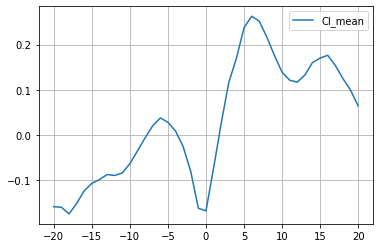

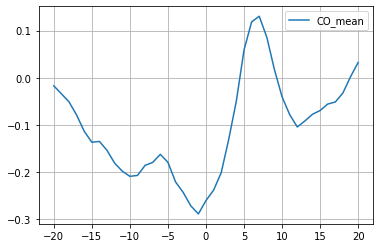

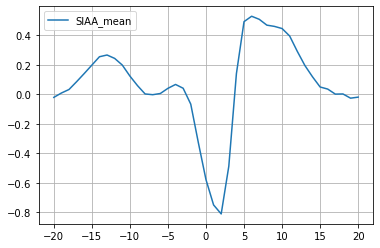

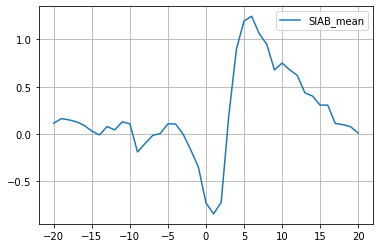

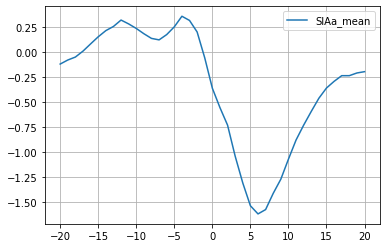

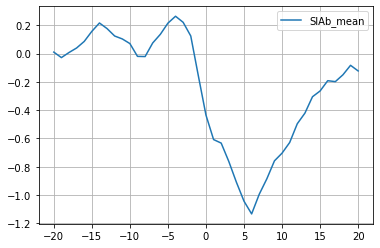

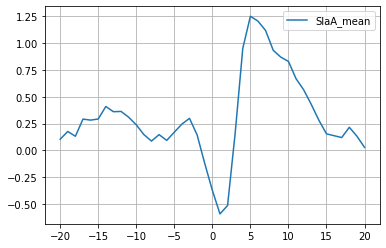

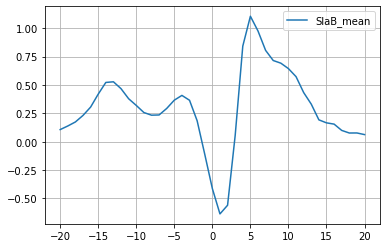

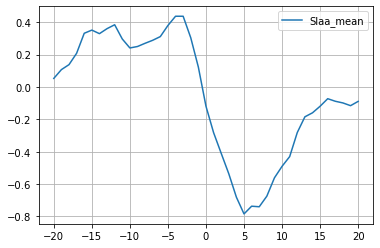

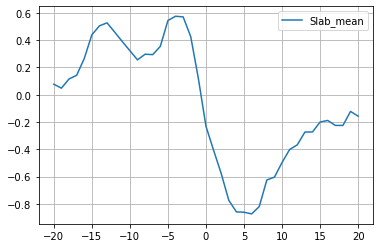

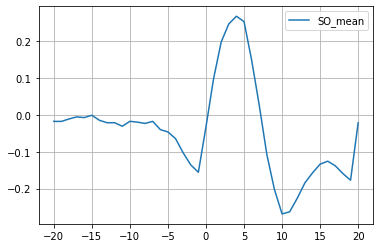

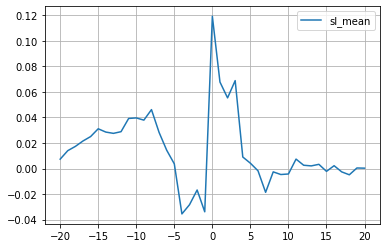

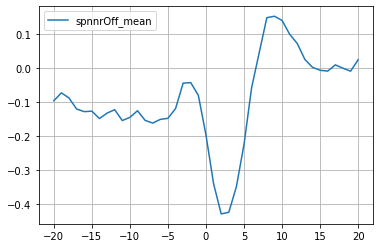

In [12]:
import matplotlib.pyplot as plt
for foc in final_out.columns:
    if 'mean' in foc:
        plt.figure()
        final_out[foc].plot(label=foc)
        plt.legend()
        plt.grid()